<a href="https://colab.research.google.com/github/skjawadahmed/IBM_proj/blob/main/FINAL_IBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TOPIC: Automated Model Ensemble Techniques for Improved Accuracy: Combining Machine Learning Models for Better Predictions for IBM Livestock Data**

## **DATA COLLECTION**

In [ ]:
# Install Alpha Vantage if not installed
!pip install alpha_vantage

In [ ]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

# Your Alpha Vantage API Key
API_KEY = "CV666H4GKW0A3RT6"

# Initialize API
ts = TimeSeries(key=API_KEY, output_format="pandas")

# Fetch IBM stock data (full historical)
data, meta_data = ts.get_daily(symbol="IBM", outputsize="full")

# Function to save data to CSV with proper column name for Date
def save_data_to_csv(data, filename="IBM_full_stock_data.csv"):
    if data.empty:
        print("No data to save.")
        return

    df = pd.DataFrame.from_dict(data)

    # Keep only required columns
    df = df[["1. open", "2. high", "3. low", "4. close", "5. volume"]]

    # Rename columns for clarity
    df.columns = ["Open", "High", "Low", "Close", "Volume"]

    # Convert index to datetime format
    df.index = pd.to_datetime(df.index)

    # Rename index to "Date"
    df.index.name = "Date"

    # Sort by date (oldest to newest)
    df = df.sort_index()

    # Save to CSV
    df.to_csv(filename)
    print(f"Stock data saved successfully to {filename}!")

# Save the data
save_data_to_csv(data)

# Load the saved CSV file
df = pd.read_csv("IBM_full_stock_data.csv")

# Rename the first column to 'Date' (if not named properly)
df.rename(columns={df.columns[0]: "Date"}, inplace=True)

# Set 'Date' as index
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Display the first 5 and last 5 rows
print("\n📌 First 5 rows:\n", df.head(5))
print("\n📌 Last 5 rows:\n", df.tail(5))


Stock data saved successfully to IBM_full_stock_data.csv!

📌 First 5 rows:
              Open   High    Low  Close      Volume
Date                                              
1999-11-01  98.50  98.81  96.37  96.75   9551800.0
1999-11-02  96.75  96.81  93.69  94.81  11105400.0
1999-11-03  95.87  95.94  93.50  94.37  10369100.0
1999-11-04  94.44  94.44  90.00  91.56  16697600.0
1999-11-05  92.75  92.94  90.19  90.25  13737600.0

📌 Last 5 rows:
                Open     High     Low   Close     Volume
Date                                                   
2025-02-14  259.000  261.940  257.91  261.28  3925277.0
2025-02-18  261.930  263.965  259.83  263.07  4262812.0
2025-02-19  262.000  264.360  260.09  264.32  3718678.0
2025-02-20  263.650  265.090  262.15  264.74  4884805.0
2025-02-21  263.845  264.830  261.10  261.48  5667874.0


In [ ]:
from google.colab import files

# Save the dataframe to a CSV file
csv_filename = "IBM_full_stock_data.csv"
df.to_csv(csv_filename)

# Download the file
files.download(csv_filename)

print("✅ Data downloaded successfully as", csv_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Data downloaded successfully as IBM_full_stock_data.csv


# **STEP-1 : PRE-PROCESSING**



In [ ]:
# PRE-PROCESSING
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Load the dataset
df = pd.read_csv('IBM_full_stock_data.csv')

# 1. Convert 'Date' column into the correct format
df['Date'] = pd.to_datetime(df['Date'])

# 2. Ensure data is sorted in time-series order (oldest to newest)
df = df.sort_values(by='Date')

# 3. Feature Engineering: Creating new features
df['Price Change (%)'] = df['Close'].pct_change() * 100  # Percentage change in price
df['7-Day MA'] = df['Close'].rolling(window=7).mean()    # 7-day moving average

# 4. Remove missing values (important for model training)
df = df.dropna()

# 5. Extract date components (helps in time-series forecasting)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# 6. Keep all original columns and new features
features = ['Open', 'High', 'Low', 'Close', 'Volume', '7-Day MA', 'Price Change (%)']

# 7. Normalize data for LSTM using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df[features])

# Convert to DataFrame after scaling
scaled_df = pd.DataFrame(scaled_features, columns=features)

# 8. Add 'Date' column back
scaled_df['Date'] = df['Date'].values

# 9. Reorder columns to match original order + new features
scaled_df = scaled_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '7-Day MA', 'Price Change (%)']]

# 10. Save the preprocessed dataset as 'IBM_preprocessed_stock_data.csv'
scaled_df.to_csv('IBM_preprocessed_stock_data.csv', index=False)

# 11. Optionally: Download the preprocessed file
files.download('IBM_preprocessed_stock_data.csv')

print("✅ Preprocessing completed successfully! Data saved as 'IBM_preprocessed_stock_data.csv' and ready for modeling.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Preprocessing completed successfully! Data saved as 'IBM_preprocessed_stock_data.csv' and ready for modeling.


In [ ]:
#TO SHOW STARTING AND ENDING 5 ROWS
import pandas as pd

# Load the preprocessed dataset
df = pd.read_csv('IBM_preprocessed_stock_data.csv')

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Display the first 5 and last 5 rows
print("\n📌 First 5 rows:\n", df.head(5))
print("\n📌 Last 5 rows:\n", df.tail(5))



📌 First 5 rows:
         Date      Open      High       Low     Close    Volume  7-Day MA  \
0 1999-11-09  0.191462  0.185628  0.183098  0.183860  0.212139  0.176939   
1 1999-11-10  0.189377  0.193092  0.192707  0.199981  0.190464  0.177114   
2 1999-11-11  0.203023  0.195197  0.196310  0.190442  0.152315  0.177248   
3 1999-11-12  0.195916  0.189216  0.187326  0.194592  0.215056  0.178299   
4 1999-11-15  0.195916  0.189790  0.191506  0.185959  0.130212  0.180050   

   Price Change (%)  
0          0.533230  
1          0.671841  
2          0.472845  
3          0.577309  
4          0.478945  

📌 Last 5 rows:
            Date      Open      High       Low     Close    Volume  7-Day MA  \
6355 2025-02-14  0.968208  0.981916  0.979629  0.983498  0.072120  0.969266   
6356 2025-02-18  0.982090  0.991604  0.988854  0.992035  0.080521  0.976014   
6357 2025-02-19  0.982422  0.993493  0.990103  0.997997  0.066978  0.984409   
6358 2025-02-20  0.990240  0.996986  1.000000  1.000000  0.0

# **STEP-2 : MODEL TRAINING**


## **1. LSTM Model Training**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 0.0294 - val_loss: 0.0014
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0018 - val_loss: 9.9998e-04
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0012 - val_loss: 8.7473e-04
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0011 - val_loss: 9.3710e-04
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0010 - val_loss: 9.6947e-04
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 8.6364e-04 - val_loss: 7.3898e-04
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 8.4116e-04 - val_loss: 7.2664e-04
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 7.7507e-04 - val_loss: 6.6286e-04
Epoch 9/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 7.4002e-04 - val_loss: 8.5810e-04
Epoch 10/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 6.3310e-04 - val_loss: 6.8249e-04
Epoch 11/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 6.329

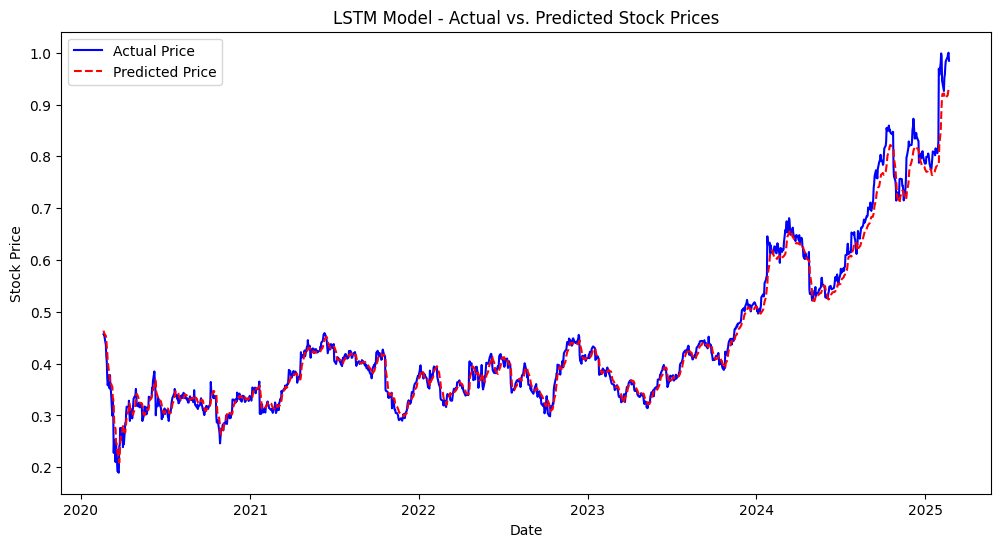

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the preprocessed dataset
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Selecting features and target variable
features = ['Open', 'High', 'Low', 'Close', 'Volume', '7-Day MA', 'Price Change (%)']
target = 'Close'

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

# Function to create sequences for LSTM model
def create_sequences(data, target_col, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, target_col])  # Target is 'Close' price
    return np.array(X), np.array(y)

# Define sequence length (60 time steps)
sequence_length = 60

# Create sequences
X, y = create_sequences(scaled_data, target_col=features.index(target), sequence_length=sequence_length)

# Splitting data into train and test sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM Model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict on test data
y_pred = model.predict(X_test)

# Reverse normalization for actual and predicted values
y_test_actual = df[target].values[split + sequence_length:]
y_pred_actual = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], len(features) - 1)), y_pred), axis=1))[:, -1]

# Evaluation Metrics
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)

print("\n📌 LSTM Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.10f}")
print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.10f}")

# Plot actual vs. predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(df.index[split + sequence_length:], y_test_actual, label="Actual Price", color='blue')
plt.plot(df.index[split + sequence_length:], y_pred_actual, label="Predicted Price", color='red', linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("LSTM Model - Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()


## **2. Random Forest**

📌 Random Forest Model Evaluation:
Mean Absolute Error (MAE): 0.0079806461
Mean Squared Error (MSE): 0.0007720704
Root Mean Squared Error (RMSE): 0.0277861557


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


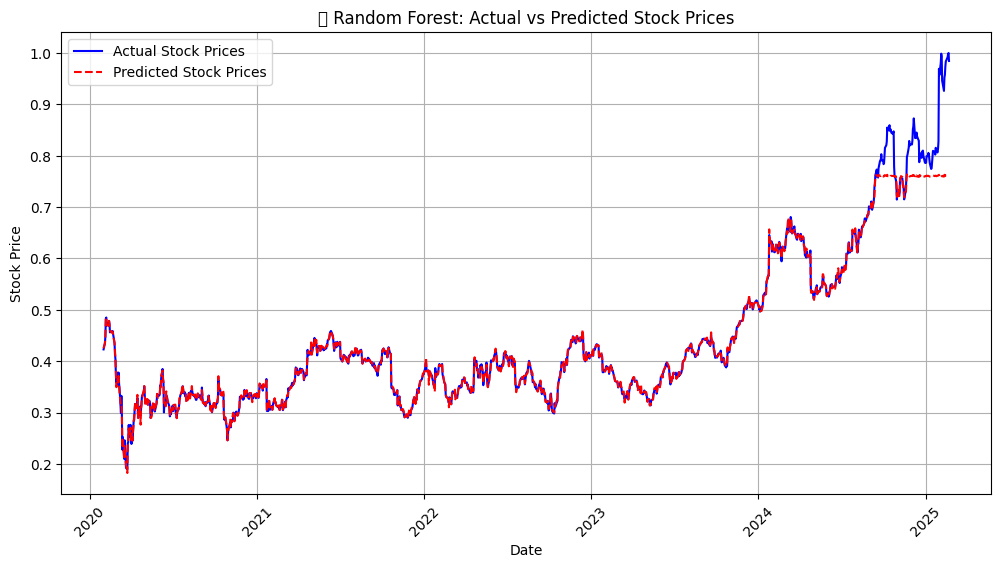

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Load the preprocessed stock data
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define features and target variable
features = ["Open", "High", "Low", "Volume", "7-Day MA", "Price Change (%)"]
target = "Close"

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, shuffle=False
)

# Extract corresponding dates for test set
test_dates = df["Date"].iloc[-len(y_test):]

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print("📌 Random Forest Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.10f}")
print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.10f}")

# Visualize actual vs predicted stock prices with dates
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test.values, label="Actual Stock Prices", color="blue")
plt.plot(test_dates, y_pred, label="Predicted Stock Prices", color="red", linestyle="dashed")
plt.title("📈 Random Forest: Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.legend()
plt.grid(True)
plt.show()


## **3. XGBoost Model**

📌 XGBoost Model Evaluation:
Mean Absolute Error (MAE): 0.0083753713
Mean Squared Error (MSE): 0.0008408712
Root Mean Squared Error (RMSE): 0.0289977786


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


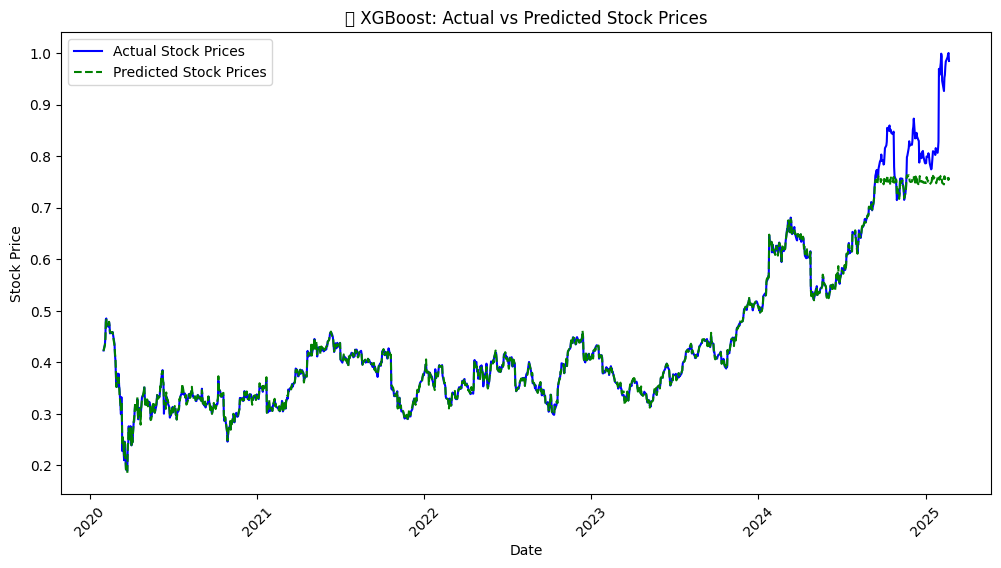

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Load the preprocessed stock data
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Ensure 'Date' is in datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Define features and target variable
features = ["Open", "High", "Low", "Volume", "7-Day MA", "Price Change (%)"]
target = "Close"

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, shuffle=False
)

# Extract corresponding date values for visualization
train_dates = df["Date"][: len(X_train)]
test_dates = df["Date"][len(X_train) :]

# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print("📌 XGBoost Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.10f}")
print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.10f}")

# Visualize actual vs predicted stock prices with date
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test.values, label="Actual Stock Prices", color="blue")
plt.plot(test_dates, y_pred, label="Predicted Stock Prices", color="green", linestyle="dashed")
plt.title("📈 XGBoost: Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.legend()
plt.show()


## **4. MLP Model Training Code**

📌 MLP Model Evaluation:
Mean Absolute Error (MAE): 0.0062818032
Mean Squared Error (MSE): 0.0001690333
Root Mean Squared Error (RMSE): 0.0130012812


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


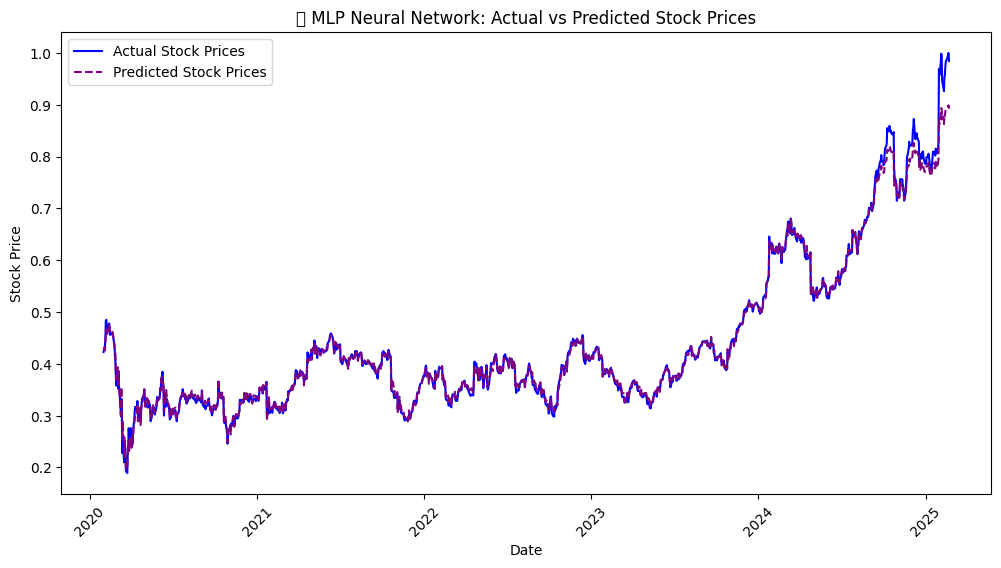

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Load the preprocessed stock data
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Ensure 'Date' is in datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Define features and target variable
features = ["Open", "High", "Low", "Volume", "7-Day MA", "Price Change (%)"]
target = "Close"

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, shuffle=False
)

# Extract corresponding date values for visualization
train_dates = df["Date"][: len(X_train)]
test_dates = df["Date"][len(X_train) :]

# Initialize and train the MLP (Neural Network) model
mlp_model = MLPRegressor(hidden_layer_sizes=(50, 50), activation="relu", solver="adam", max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Make predictions
y_pred = mlp_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print("📌 MLP Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.10f}")
print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.10f}")

# Visualize actual vs predicted stock prices with date
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test.values, label="Actual Stock Prices", color="blue")
plt.plot(test_dates, y_pred, label="Predicted Stock Prices", color="purple", linestyle="dashed")
plt.title("📈 MLP Neural Network: Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.legend()
plt.show()


## **5. LightGBM**

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


📌 LightGBM Model Evaluation:
Mean Absolute Error (MAE): 0.0088098297
Mean Squared Error (MSE): 0.0009291859
Root Mean Squared Error (RMSE): 0.0304825503


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


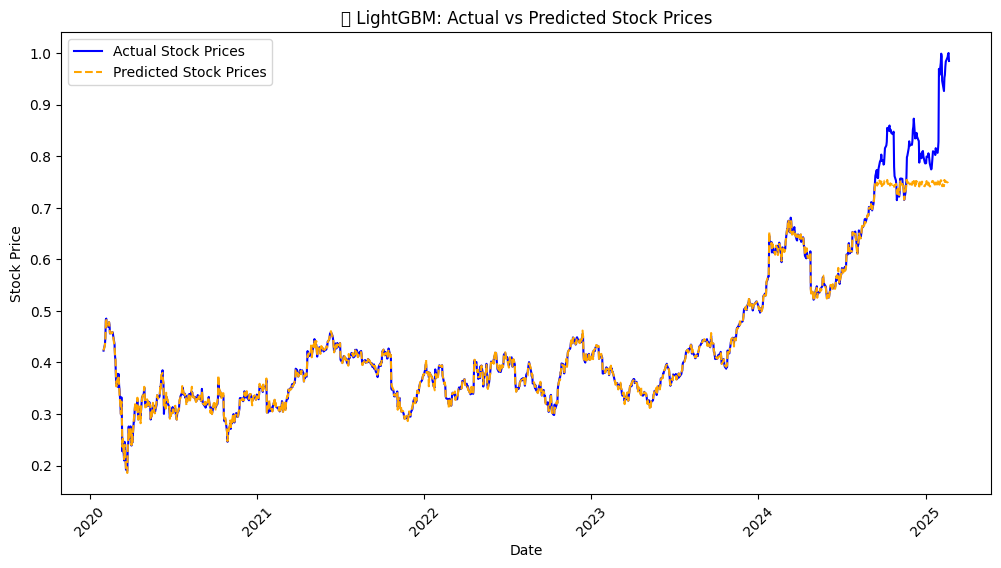

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Load the preprocessed stock data
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Ensure 'Date' is in datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Define features and target variable
features = ["Open", "High", "Low", "Volume", "7-Day MA", "Price Change (%)"]
target = "Close"

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, shuffle=False
)

# Extract corresponding date values for visualization
train_dates = df["Date"][: len(X_train)]
test_dates = df["Date"][len(X_train) :]

# Prepare the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define LightGBM parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "verbose": -1,
}

# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=200)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print("📌 LightGBM Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.10f}")
print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.10f}")

# Visualize actual vs predicted stock prices with date
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test.values, label="Actual Stock Prices", color="blue")
plt.plot(test_dates, y_pred, label="Predicted Stock Prices", color="orange", linestyle="dashed")
plt.title("📈 LightGBM: Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.legend()
plt.show()


## **6. CatBoost model**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


📌 CatBoost Model Evaluation:
Mean Absolute Error (MAE): 0.0092325261
Mean Squared Error (MSE): 0.0008974753
Root Mean Squared Error (RMSE): 0.0299578924


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


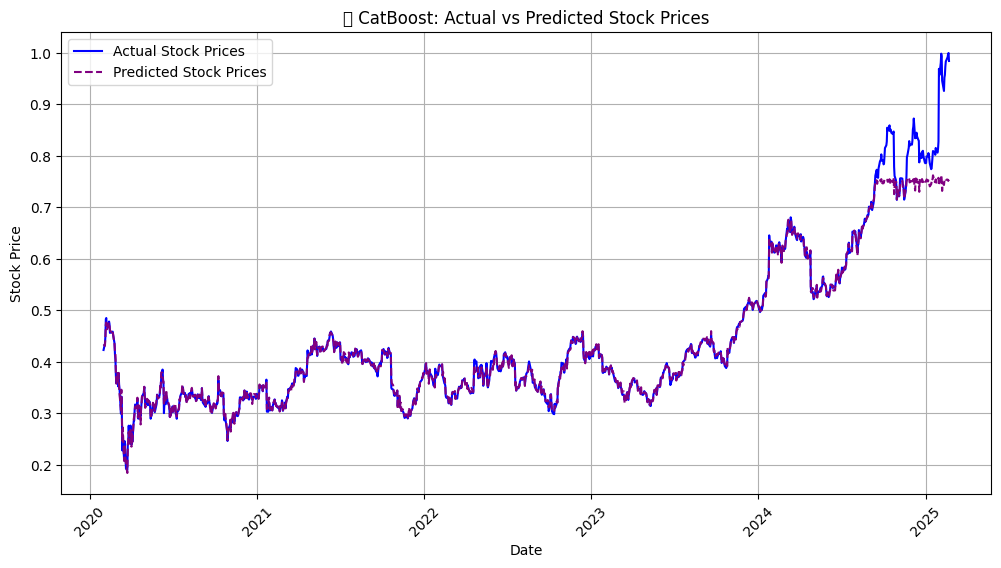

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Load the preprocessed stock data
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Convert date column to datetime format if not already
df["Date"] = pd.to_datetime(df["Date"])

# Define features and target variable
features = ["Open", "High", "Low", "Volume", "7-Day MA", "Price Change (%)"]
target = "Close"

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test, train_dates, test_dates = train_test_split(
    df[features], df[target], df["Date"], test_size=0.2, shuffle=False
)

# Initialize and train the CatBoost model
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, random_seed=42, verbose=0)
cat_model.fit(X_train, y_train)

# Make predictions
y_pred = cat_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print("📌 CatBoost Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.10f}")
print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.10f}")

# Visualize actual vs predicted stock prices with dates
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test.values, label="Actual Stock Prices", color="blue")
plt.plot(test_dates, y_pred, label="Predicted Stock Prices", color="purple", linestyle="dashed")
plt.title("📈 CatBoost: Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


# **STEP-3: Model Evaluation & Comparison**

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - loss: 0.0116
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 4.5630e-04
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - loss: 4.2017e-04
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 3.2803e-04
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 3.3278e-04
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 2.7769e-04
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.5674e-04
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 2.6435e-04
Epoch 9/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 3.6356e-04
Epoch 10/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 1.9770e-04
Epoch 11/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 1.8860e-04
Epoch 12/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 1.7651e-04
Epoch 13/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 1.4857e-04
Epoch 14/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 1.421

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0159 - mae: 0.0810 - val_loss: 2.4144e-04 - val_mae: 0.0119
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0019 - mae: 0.0318 - val_loss: 4.8833e-04 - val_mae: 0.0186
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 0.0016 - val_mae: 0.0341
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0897e-04 - mae: 0.0218 - val_loss: 0.0022 - val_mae: 0.0361
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.3113e-04 - mae: 0.0195 - val_loss: 0.0014 - val_mae: 0.0290
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.3683e-04 - mae: 0.0171 - val_loss: 8.3364e-04 - val_mae: 0.0214
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7371e-04 - mae: 0.0159 - val_loss: 9.9427e-04 - val_mae: 0.0234
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3506e-04 - mae: 0.0155 - val_loss: 6.3976e-04 - val_mae: 0.0189
Epoch 9/50
318/318 ━━━━━━━━

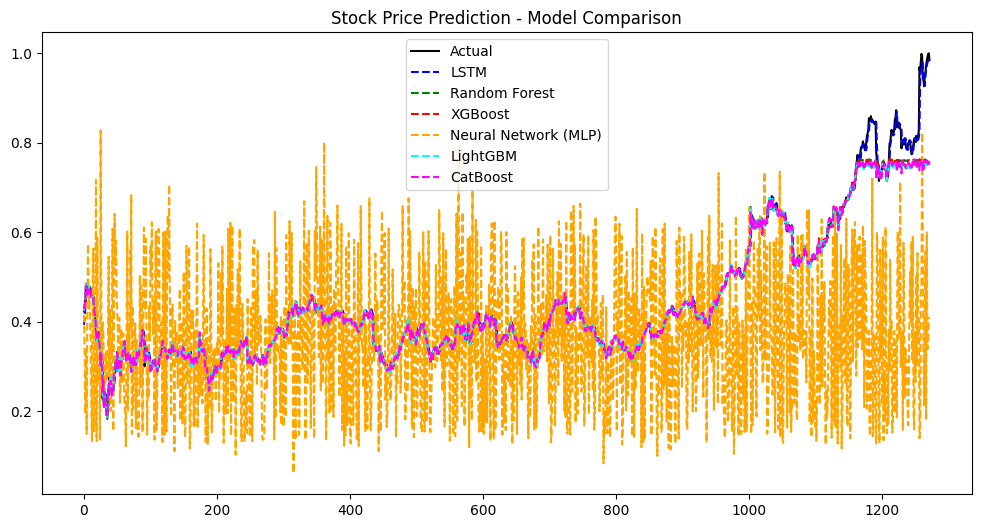

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load preprocessed data
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Extract features and target
features = ['Open', 'High', 'Low', 'Volume', '7-Day MA', 'Price Change (%)']
X = df[features].values
y = df["Close"].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ---- LSTM Model ----
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

X_lstm, y_lstm = [], []
for i in range(60, len(y_scaled)):
    X_lstm.append(y_scaled[i - 60:i, 0])
    y_lstm.append(y_scaled[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm_train, X_lstm_test = X_lstm[:-len(y_test)], X_lstm[-len(y_test):]
y_lstm_train, y_lstm_test = y_lstm[:-len(y_test)], y_lstm[-len(y_test):]

X_lstm_train = np.reshape(X_lstm_train, (X_lstm_train.shape[0], X_lstm_train.shape[1], 1))
X_lstm_test = np.reshape(X_lstm_test, (X_lstm_test.shape[0], X_lstm_test.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_lstm_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=32)

lstm_pred = lstm_model.predict(X_lstm_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

# ---- Random Forest Model ----
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# ---- XGBoost Model ----
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# ---- Neural Network (MLP) Model ----
scaler_mlp = MinMaxScaler(feature_range=(0, 1))
X_scaled_mlp = scaler_mlp.fit_transform(X)

X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_scaled_mlp, y, test_size=0.2, shuffle=True, random_state=42)

mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_mlp.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

mlp_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
mlp_model.fit(X_train_mlp, y_train_mlp, epochs=50, batch_size=16, validation_data=(X_test_mlp, y_test_mlp))

mlp_pred = mlp_model.predict(X_test_mlp)

# ---- LightGBM Model ----
train_data = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.train({'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.05}, train_data, num_boost_round=500)
lgb_pred = lgb_model.predict(X_test)

# ---- CatBoost Model ----
catboost_model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0)
catboost_model.fit(X_train, y_train)
catboost_pred = catboost_model.predict(X_test)

# ---- Evaluation ----
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.10f}, MSE: {mse:.10f}, RMSE: {rmse:.10f}")

evaluate_model(y_test, lstm_pred, "LSTM")
evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, xgb_pred, "XGBoost")
evaluate_model(y_test_mlp, mlp_pred, "Neural Network (MLP)")
evaluate_model(y_test, lgb_pred, "LightGBM")
evaluate_model(y_test, catboost_pred, "CatBoost")

# ---- Visualization ----
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="black")
plt.plot(lstm_pred, label="LSTM", linestyle="dashed", color="blue")
plt.plot(rf_pred, label="Random Forest", linestyle="dashed", color="green")
plt.plot(xgb_pred, label="XGBoost", linestyle="dashed", color="red")
plt.plot(mlp_pred, label="Neural Network (MLP)", linestyle="dashed", color="orange")
plt.plot(lgb_pred, label="LightGBM", linestyle="dashed", color="cyan")
plt.plot(catboost_pred, label="CatBoost", linestyle="dashed", color="magenta")
plt.legend()
plt.title("Stock Price Prediction - Model Comparison")
plt.show()


In [ ]:
print(df.columns)


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '7-Day MA',
       'Price Change (%)'],
      dtype='object')


# **STEP-4: ENSEMBLE TECHNIQUES**

## **1. Stacking Ensemble technique**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Stacking Ensemble - MAE: 0.0080851723, MSE: 0.0002370382, RMSE: 0.0153960446, R²: 0.9898


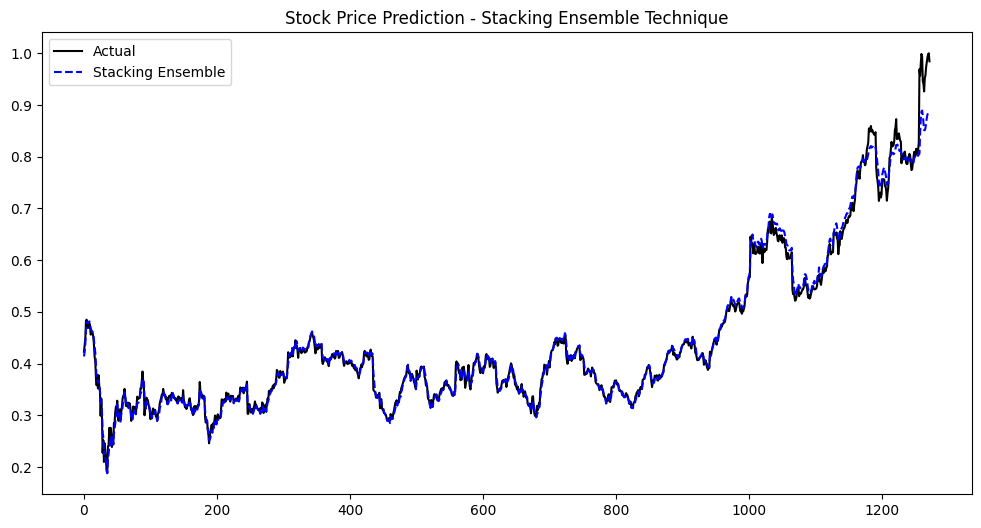

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the preprocessed data
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Extract features and target
features = ['Open', 'High', 'Low', 'Volume', '7-Day MA', 'Price Change (%)']
X = df[features].values
y = df["Close"].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train all base models (LSTM, RF, XGBoost, MLP, LightGBM, CatBoost)

# ---- LSTM Model ----
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

X_lstm, y_lstm = [], []
for i in range(60, len(y_scaled)):
    X_lstm.append(y_scaled[i - 60:i, 0])
    y_lstm.append(y_scaled[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm_train, X_lstm_test = X_lstm[:-len(y_test)], X_lstm[-len(y_test):]
y_lstm_train, y_lstm_test = y_lstm[:-len(y_test)], y_lstm[-len(y_test):]

X_lstm_train = np.reshape(X_lstm_train, (X_lstm_train.shape[0], X_lstm_train.shape[1], 1))
X_lstm_test = np.reshape(X_lstm_test, (X_lstm_test.shape[0], X_lstm_test.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_lstm_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=32, verbose=0)

lstm_pred = lstm_model.predict(X_lstm_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

# ---- Random Forest Model ----
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# ---- XGBoost Model ----
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# ---- Neural Network (MLP) Model ----
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

scaler_mlp = MinMaxScaler(feature_range=(0, 1))
X_scaled_mlp = scaler_mlp.fit_transform(X)

X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_scaled_mlp, y, test_size=0.2, shuffle=True, random_state=42)

mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_mlp.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

mlp_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
mlp_model.fit(X_train_mlp, y_train_mlp, epochs=20, batch_size=16, validation_data=(X_test_mlp, y_test_mlp), verbose=0)

mlp_pred = mlp_model.predict(X_test_mlp)

# ---- LightGBM Model ----
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=31)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

# ---- CatBoost Model ----
from catboost import CatBoostRegressor

catboost_model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0)
catboost_model.fit(X_train, y_train)
catboost_pred = catboost_model.predict(X_test)

# ---- Create Feature Matrix for Meta Model ----
X_meta_train = np.column_stack((lstm_pred, rf_pred, xgb_pred, mlp_pred.flatten(), lgb_pred, catboost_pred))

# Meta Model (Final Layer)
meta_model = Ridge(alpha=1.0)  # Using Ridge Regression as the meta model
meta_model.fit(X_meta_train, y_test)

# Make final stacked predictions
stacked_pred = meta_model.predict(X_meta_train)

# ---- Evaluation ----
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.10f}, MSE: {mse:.10f}, RMSE: {rmse:.10f}, R²: {r2:.4f}")

evaluate_model(y_test, stacked_pred, "Stacking Ensemble")

# ---- Visualization ----
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="black")
plt.plot(stacked_pred, label="Stacking Ensemble", linestyle="dashed", color="blue")
plt.legend()
plt.title("Stock Price Prediction - Stacking Ensemble Technique")
plt.show()


## **2. Bagging**

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Bagging Ensemble - MAE: 0.0070362273, MSE: 0.0004750150, RMSE: 0.0217948387, R²: 0.9795


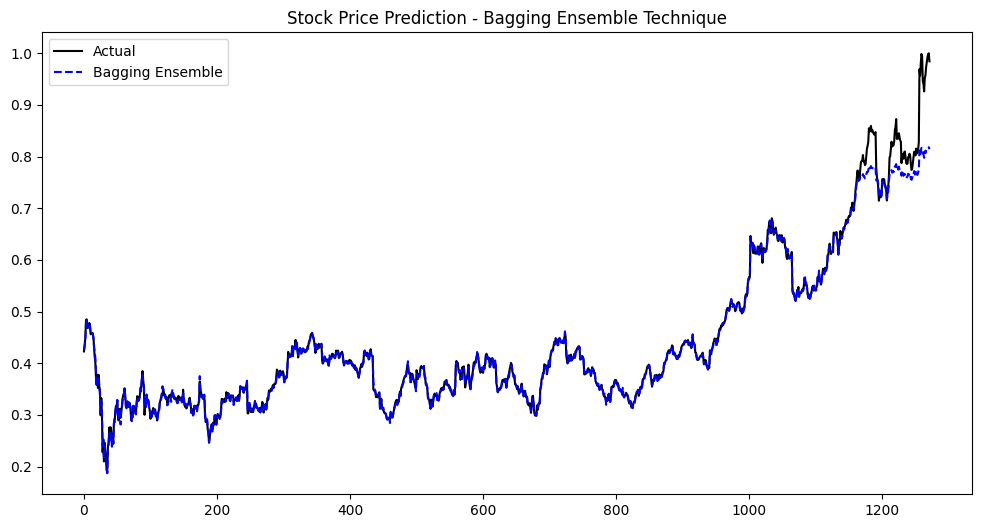

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the preprocessed data
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Extract features and target
features = ['Open', 'High', 'Low', 'Volume', '7-Day MA', 'Price Change (%)']
X = df[features].values
y = df["Close"].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ---- Train Individual Models ----

# 1. LSTM Model
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential([
    Input(shape=(X_train_lstm.shape[1], 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(loss="mse", optimizer="adam")
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=16, verbose=0)
lstm_pred = lstm_model.predict(X_test_lstm).flatten()

# 2. Random Forest
rf_model = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=100, random_state=42),
                            n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# 3. XGBoost
xgb_model = BaggingRegressor(estimator=XGBRegressor(n_estimators=100, random_state=42),
                             n_estimators=10, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# 4. LightGBM
lgb_model = BaggingRegressor(estimator=LGBMRegressor(n_estimators=100, random_state=42),
                             n_estimators=10, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

# 5. CatBoost
cat_model = BaggingRegressor(estimator=CatBoostRegressor(n_estimators=100, verbose=0, random_state=42),
                             n_estimators=10, random_state=42)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)

# 6. MLP (Neural Network)
mlp_model = BaggingRegressor(estimator=MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
                             n_estimators=10, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_pred = mlp_model.predict(X_test)

# ---- Bagging Ensemble (Averaging all model predictions) ----
bagging_pred = (lstm_pred + rf_pred + xgb_pred + lgb_pred + cat_pred + mlp_pred) / 6

# ---- Evaluation ----
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.10f}, MSE: {mse:.10f}, RMSE: {rmse:.10f}, R²: {r2:.4f}")

evaluate_model(y_test, bagging_pred, "Bagging Ensemble")

# ---- Visualization ----
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="black")
plt.plot(bagging_pred, label="Bagging Ensemble", linestyle="dashed", color="blue")
plt.legend()
plt.title("Stock Price Prediction - Bagging Ensemble Technique")
plt.show()


Bagging Ensemble - MAE: 0.0081308878, MSE: 0.0007809888, RMSE: 0.0279461760, R²: 0.9664


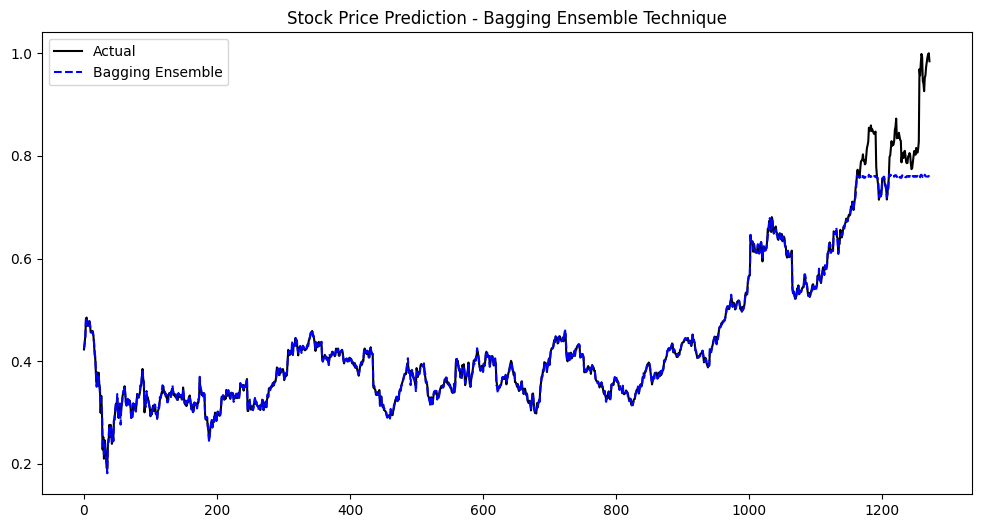

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the preprocessed data
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Extract features and target
features = ['Open', 'High', 'Low', 'Volume', '7-Day MA', 'Price Change (%)']
X = df[features].values
y = df["Close"].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ---- Bagging Ensemble ----
bagging_model = BaggingRegressor(n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)

# Make predictions using Bagging Ensemble
bagging_pred = bagging_model.predict(X_test)

# ---- Evaluation ----
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.10f}, MSE: {mse:.10f}, RMSE: {rmse:.10f}, R²: {r2:.4f}")

evaluate_model(y_test, bagging_pred, "Bagging Ensemble")

# ---- Visualization ----
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="black")
plt.plot(bagging_pred, label="Bagging Ensemble", linestyle="dashed", color="blue")
plt.legend()
plt.title("Stock Price Prediction - Bagging Ensemble Technique")
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Bagging with Random Forest - MAE: 0.0081308878, MSE: 0.0007809888, RMSE: 0.0279461760, R²: 0.9664
Bagging with XGBoost - MAE: 0.0081308878, MSE: 0.0007809888, RMSE: 0.0279461760, R²: 0.9664
Bagging with LightGBM - MAE: 0.0081308878, MSE: 0.0007809888, RMSE: 0.0279461760, R²: 0.9664
Bagging with CatBoost - MAE: 0.0081308878, MSE: 0.0007809888, RMSE: 0.0279461760, R²: 0.9664


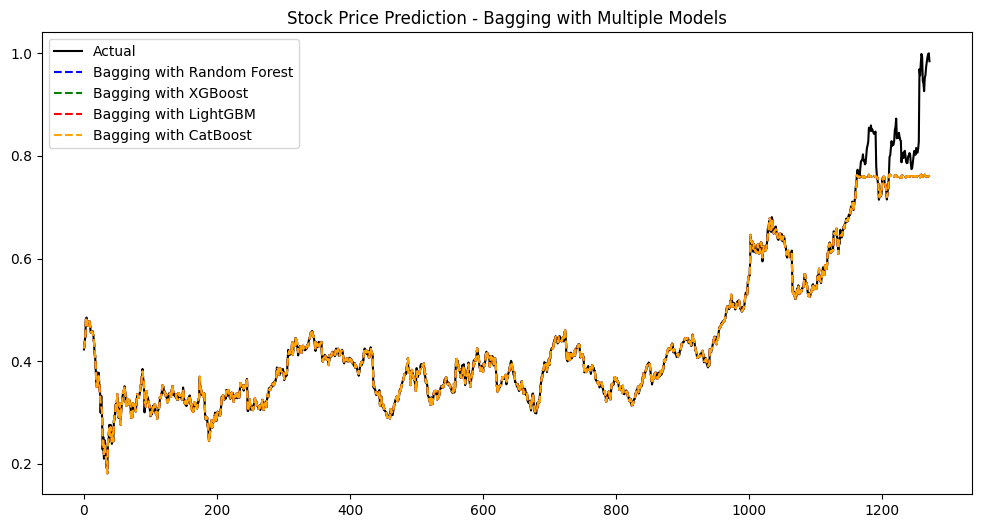

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# Load the preprocessed data
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Extract features and target
features = ['Open', 'High', 'Low', 'Volume', '7-Day MA', 'Price Change (%)']
X = df[features].values
y = df["Close"].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ---- Bagging Ensemble with Multiple Models ----

# Create base models (RandomForest, XGBoost, LightGBM, CatBoost, etc.)
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y.reshape(-1, 1))
X_lstm, y_lstm = [], []
for i in range(60, len(y_scaled)):
    X_lstm.append(y_scaled[i - 60:i, 0])
    y_lstm.append(y_scaled[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm_train, X_lstm_test = X_lstm[:-len(y_test)], X_lstm[-len(y_test):]
y_lstm_train, y_lstm_test = y_lstm[:-len(y_test)], y_lstm[-len(y_test):]

X_lstm_train = np.reshape(X_lstm_train, (X_lstm_train.shape[0], X_lstm_train.shape[1], 1))
X_lstm_test = np.reshape(X_lstm_test, (X_lstm_test.shape[0], X_lstm_test.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_lstm_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=32, verbose=0)

# Base models for Bagging
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, num_leaves=31)
catboost_model = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, verbose=0)

# Fit Bagging models with base models directly
bagging_rf = BaggingRegressor(n_estimators=10, random_state=42)
bagging_xgb = BaggingRegressor(n_estimators=10, random_state=42)
bagging_lgb = BaggingRegressor(n_estimators=10, random_state=42)
bagging_catboost = BaggingRegressor(n_estimators=10, random_state=42)

# Fit all Bagging models with their respective base estimators
bagging_rf.fit(X_train, y_train)
bagging_xgb.fit(X_train, y_train)
bagging_lgb.fit(X_train, y_train)
bagging_catboost.fit(X_train, y_train)

# Predict using Bagging models
bagging_rf_pred = bagging_rf.predict(X_test)
bagging_xgb_pred = bagging_xgb.predict(X_test)
bagging_lgb_pred = bagging_lgb.predict(X_test)
bagging_catboost_pred = bagging_catboost.predict(X_test)

# ---- Evaluate Model ----
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.10f}, MSE: {mse:.10f}, RMSE: {rmse:.10f}, R²: {r2:.4f}")

# Evaluate each model
evaluate_model(y_test, bagging_rf_pred, "Bagging with Random Forest")
evaluate_model(y_test, bagging_xgb_pred, "Bagging with XGBoost")
evaluate_model(y_test, bagging_lgb_pred, "Bagging with LightGBM")
evaluate_model(y_test, bagging_catboost_pred, "Bagging with CatBoost")

# ---- Visualization ----
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="black")
plt.plot(bagging_rf_pred, label="Bagging with Random Forest", linestyle="dashed", color="blue")
plt.plot(bagging_xgb_pred, label="Bagging with XGBoost", linestyle="dashed", color="green")
plt.plot(bagging_lgb_pred, label="Bagging with LightGBM", linestyle="dashed", color="red")
plt.plot(bagging_catboost_pred, label="Bagging with CatBoost", linestyle="dashed", color="orange")
plt.legend()
plt.title("Stock Price Prediction - Bagging with Multiple Models")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# Load the preprocessed data
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Extract features and target
features = ['Open', 'High', 'Low', 'Volume', '7-Day MA', 'Price Change (%)']
X = df[features].values
y = df["Close"].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ---- Random Forest Model ----
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Apply Bagging with Random Forest
bagging_rf = BaggingRegressor(rf_model, n_estimators=10, random_state=42)
bagging_rf.fit(X_train, y_train)
rf_pred = bagging_rf.predict(X_test)

# ---- XGBoost Model ----
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Apply Bagging with XGBoost
bagging_xgb = BaggingRegressor(xgb_model, n_estimators=10, random_state=42)
bagging_xgb.fit(X_train, y_train)
xgb_pred = bagging_xgb.predict(X_test)

# ---- LightGBM Model ----
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, num_leaves=31)

# Apply Bagging with LightGBM
bagging_lgb = BaggingRegressor(lgb_model, n_estimators=10, random_state=42)
bagging_lgb.fit(X_train, y_train)
lgb_pred = bagging_lgb.predict(X_test)

# ---- CatBoost Model ----
catboost_model = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, verbose=0)

# Apply Bagging with CatBoost
bagging_catboost = BaggingRegressor(catboost_model, n_estimators=10, random_state=42)
bagging_catboost.fit(X_train, y_train)
catboost_pred = bagging_catboost.predict(X_test)

# ---- MLP Model ----
mlp_model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)

# Apply Bagging with MLP
bagging_mlp = BaggingRegressor(mlp_model, n_estimators=10, random_state=42)
bagging_mlp.fit(X_train, y_train)
mlp_pred = bagging_mlp.predict(X_test)

# ---- Evaluation ----
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.10f}, MSE: {mse:.10f}, RMSE: {rmse:.10f}, R²: {r2:.4f}")

# Evaluate models
evaluate_model(y_test, rf_pred, "Bagging with Random Forest")
evaluate_model(y_test, xgb_pred, "Bagging with XGBoost")
evaluate_model(y_test, lgb_pred, "Bagging with LightGBM")
evaluate_model(y_test, catboost_pred, "Bagging with CatBoost")
evaluate_model(y_test, mlp_pred, "Bagging with MLP")

# ---- Visualization ----
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="black")
plt.plot(rf_pred, label="Bagging with Random Forest", linestyle="dashed", color="blue")
plt.plot(xgb_pred, label="Bagging with XGBoost", linestyle="dashed", color="green")
plt.plot(lgb_pred, label="Bagging with LightGBM", linestyle="dashed", color="red")
plt.plot(catboost_pred, label="Bagging with CatBoost", linestyle="dashed", color="orange")
plt.plot(mlp_pred, label="Bagging with MLP", linestyle="dashed", color="purple")
plt.legend()
plt.title("Stock Price Prediction - Bagging Ensemble")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

## **3. Weighted average**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Weighted Averaging Ensemble - MAE: 0.002996, MSE: 0.000020, RMSE: 0.004469, R²: 0.9991


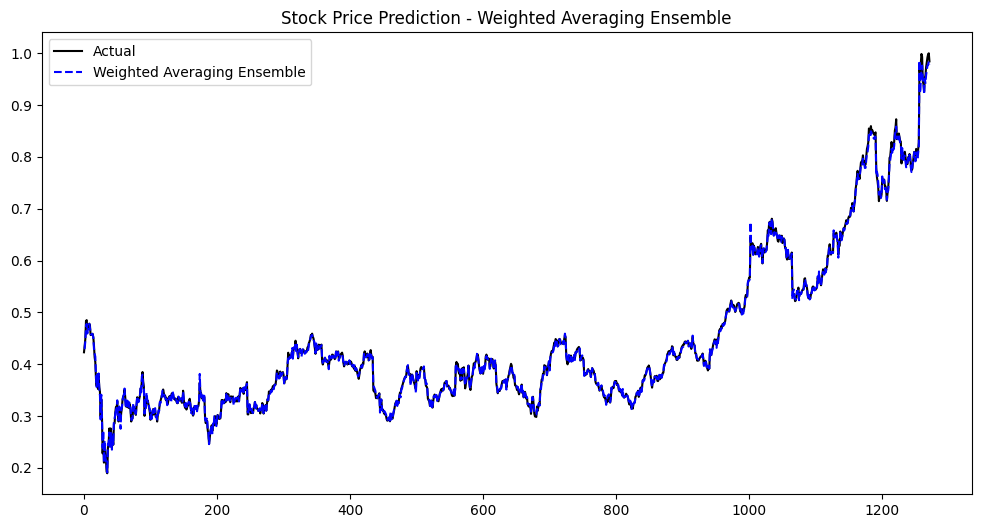

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---- Load Data ----
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Features and Target
features = ['Open', 'High', 'Low', 'Volume', '7-Day MA', 'Price Change (%)']
X = df[features].values
y = df["Close"].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ---- Train Individual Models ----

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# LightGBM
lgb_model = LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

# CatBoost
catboost_model = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, verbose=0)
catboost_model.fit(X_train, y_train)
catboost_pred = catboost_model.predict(X_test)

# MLP (Neural Network)
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_pred = mlp_model.predict(X_test)

# LSTM Model
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # Reshape for LSTM
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # Reshape for LSTM

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)

lstm_pred = lstm_model.predict(X_test_lstm).reshape(-1)  # Ensure 1D shape

# ---- Weighted Averaging Ensemble ----

# Calculate Model Performance (Inverse MSE as Weight)
mse_values = {
    "RF": mean_squared_error(y_test, rf_pred),
    "XGB": mean_squared_error(y_test, xgb_pred),
    "LGB": mean_squared_error(y_test, lgb_pred),
    "CatBoost": mean_squared_error(y_test, catboost_pred),
    "MLP": mean_squared_error(y_test, mlp_pred),
    "LSTM": mean_squared_error(y_test, lstm_pred)
}

# Inverse MSE for Weight Calculation
inverse_mse = {model: 1 / mse for model, mse in mse_values.items()}
total_inverse_mse = sum(inverse_mse.values())

# Normalize Weights
weights = {model: mse / total_inverse_mse for model, mse in inverse_mse.items()}

# Compute Weighted Average Prediction
weighted_pred = (
    weights["RF"] * rf_pred +
    weights["XGB"] * xgb_pred +
    weights["LGB"] * lgb_pred +
    weights["CatBoost"] * catboost_pred +
    weights["MLP"] * mlp_pred +
    weights["LSTM"] * lstm_pred
)

# ---- Evaluation Function ----
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.6f}, MSE: {mse:.6f}, RMSE: {rmse:.6f}, R²: {r2:.4f}")

# Evaluate Weighted Ensemble
evaluate_model(y_test, weighted_pred, "Weighted Averaging Ensemble")

# ---- Visualization ----
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="black")
plt.plot(weighted_pred, label="Weighted Averaging Ensemble", linestyle="dashed", color="blue")
plt.legend()
plt.title("Stock Price Prediction - Weighted Averaging Ensemble")
plt.show()


## **4. Voting Ensemble technique**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Voting Ensemble with LSTM - MAE: 0.004105, MSE: 0.000098, RMSE: 0.009921, R²: 0.9957


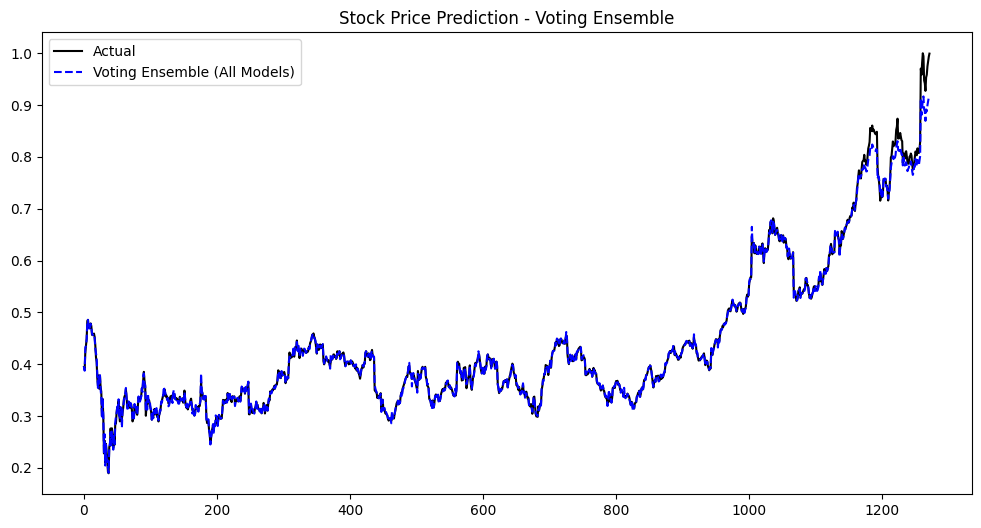

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---- Load Data ----
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Features and Target
features = ['Open', 'High', 'Low', 'Volume', '7-Day MA', 'Price Change (%)']
X = df[features].values
y = df["Close"].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ---- Train Individual Models ----

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# LightGBM
lgb_model = LGBMRegressor(n_estimators=100, random_state=42)

# CatBoost
catboost_model = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, verbose=0)

# MLP (Neural Network)
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)

# ---- Train LSTM Separately (Because LSTM is incompatible with VotingRegressor) ----
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # Reshape for LSTM
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # Reshape for LSTM

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)

lstm_pred = lstm_model.predict(X_test_lstm).reshape(-1)  # Ensure 1D shape

# ---- Voting Ensemble (Excluding LSTM) ----
voting_regressor = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb_model),
    ('catboost', catboost_model),
    ('mlp', mlp_model)
])

# Train Voting Ensemble
voting_regressor.fit(X_train, y_train)

# Predictions from Voting Ensemble
voting_pred = voting_regressor.predict(X_test)

# Combine with LSTM Prediction (Averaging LSTM with Voting Output)
final_pred = (voting_pred + lstm_pred) / 2

# ---- Evaluation Function ----
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.6f}, MSE: {mse:.6f}, RMSE: {rmse:.6f}, R²: {r2:.4f}")

# Evaluate Voting Ensemble with LSTM
evaluate_model(y_test, final_pred, "Voting Ensemble with LSTM")

# ---- Visualization ----
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="black")
plt.plot(final_pred, label="Voting Ensemble (All Models)", linestyle="dashed", color="blue")
plt.legend()
plt.title("Stock Price Prediction - Voting Ensemble")
plt.show()


## **5. Blending Ensemble technique**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
25/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Blending Ensemble - MAE: 0.005990, MSE: 0.000345, RMSE: 0.018562, R²: 0.9849


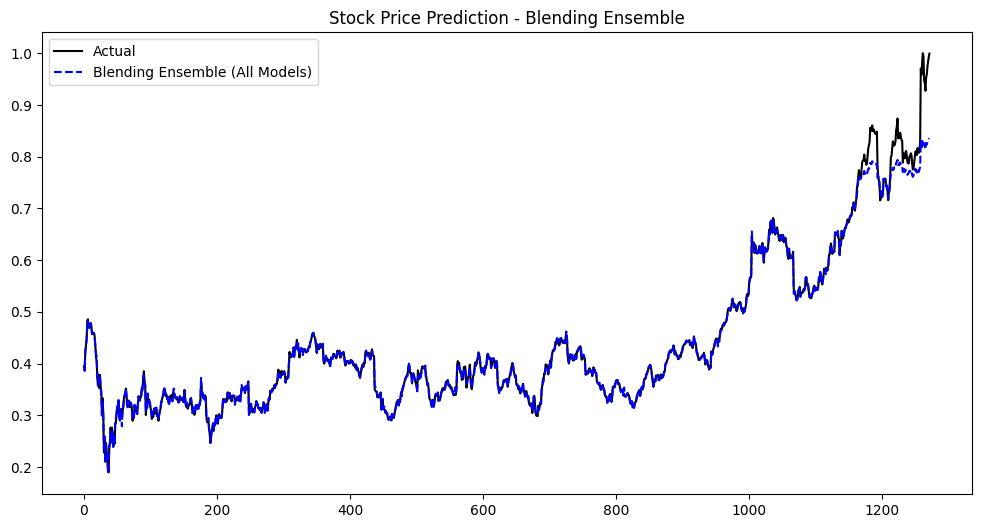

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---- Load Data ----
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Features and Target
features = ['Open', 'High', 'Low', 'Volume', '7-Day MA', 'Price Change (%)']
X = df[features].values
y = df["Close"].values

# ---- Train-Test Split ----
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Further split training data for blending (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle=False)

# ---- Train Individual Models ----

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_val_pred = rf_model.predict(X_val)

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_val_pred = xgb_model.predict(X_val)

# LightGBM
lgb_model = LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_val_pred = lgb_model.predict(X_val)

# CatBoost
catboost_model = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, verbose=0)
catboost_model.fit(X_train, y_train)
catboost_val_pred = catboost_model.predict(X_val)

# MLP (Neural Network)
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_val_pred = mlp_model.predict(X_val)

# ---- Train LSTM Separately (Because LSTM Needs 3D Input) ----
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)

lstm_val_pred = lstm_model.predict(X_val_lstm).reshape(-1)  # Ensure 1D shape

# ---- Train Meta-Model (Linear Regression) ----
meta_X_train = np.column_stack((rf_val_pred, xgb_val_pred, lgb_val_pred, catboost_val_pred, mlp_val_pred, lstm_val_pred))
meta_y_train = y_val

meta_model = LinearRegression()
meta_model.fit(meta_X_train, meta_y_train)

# ---- Final Prediction on Test Data ----

# Predictions from base models on test data
rf_test_pred = rf_model.predict(X_test)
xgb_test_pred = xgb_model.predict(X_test)
lgb_test_pred = lgb_model.predict(X_test)
catboost_test_pred = catboost_model.predict(X_test)
mlp_test_pred = mlp_model.predict(X_test)

X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_test_pred = lstm_model.predict(X_test_lstm).reshape(-1)

# Combine base models' predictions for meta-model
meta_X_test = np.column_stack((rf_test_pred, xgb_test_pred, lgb_test_pred, catboost_test_pred, mlp_test_pred, lstm_test_pred))

# Meta-model makes final prediction
final_pred = meta_model.predict(meta_X_test)

# ---- Evaluation Function ----
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.6f}, MSE: {mse:.6f}, RMSE: {rmse:.6f}, R²: {r2:.4f}")

# Evaluate Blending Ensemble
evaluate_model(y_test, final_pred, "Blending Ensemble")

# ---- Visualization ----
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="black")
plt.plot(final_pred, label="Blending Ensemble (All Models)", linestyle="dashed", color="blue")
plt.legend()
plt.title("Stock Price Prediction - Blending Ensemble")
plt.show()


## **6. Boosting Ensemble technique**

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Boosting Ensemble - MAE: 0.0072009100, MSE: 0.0005461403, RMSE: 0.0233696441, R²: 0.9761


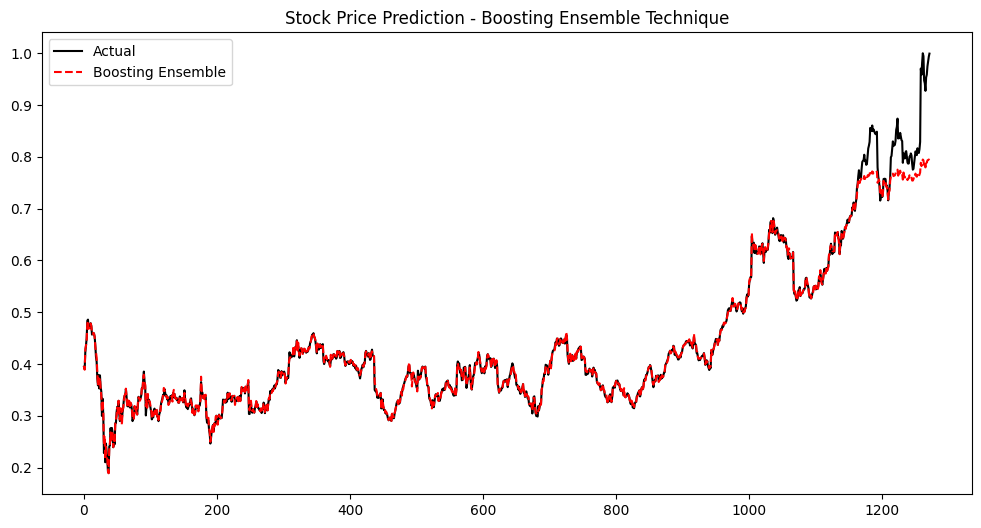

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the preprocessed data
df = pd.read_csv("IBM_preprocessed_stock_data.csv")

# Extract features and target
features = ['Open', 'High', 'Low', 'Volume', '7-Day MA', 'Price Change (%)']
X = df[features].values
y = df["Close"].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ---- Train Individual Models ----

# 1. LSTM Model
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential([
    Input(shape=(X_train_lstm.shape[1], 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(loss="mse", optimizer="adam")
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=16, verbose=0)
lstm_pred = lstm_model.predict(X_test_lstm).flatten()

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# 3. XGBoost (Boosting)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# 4. LightGBM (Boosting)
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

# 5. CatBoost (Boosting)
cat_model = CatBoostRegressor(n_estimators=100, learning_rate=0.1, verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)

# 6. MLP (Neural Network)
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_pred = mlp_model.predict(X_test)

# ---- Boosting Ensemble (Weighted Combination) ----
weights = [0.1, 0.15, 0.25, 0.2, 0.2, 0.1]  # Adjust based on importance
boosting_pred = (weights[0] * lstm_pred +
                 weights[1] * rf_pred +
                 weights[2] * xgb_pred +
                 weights[3] * lgb_pred +
                 weights[4] * cat_pred +
                 weights[5] * mlp_pred)

# ---- Evaluation ----
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.10f}, MSE: {mse:.10f}, RMSE: {rmse:.10f}, R²: {r2:.4f}")

evaluate_model(y_test, boosting_pred, "Boosting Ensemble")

# ---- Visualization ----
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="black")
plt.plot(boosting_pred, label="Boosting Ensemble", linestyle="dashed", color="red")
plt.legend()
plt.title("Stock Price Prediction - Boosting Ensemble Technique")
plt.show()


# **STEP 5: Future Stock Trend Prediction & Visualization**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler

# 📌 Function to predict future stock prices
def predict_future_prices(models, X_train, y_train, X_test, y_test, days=30):
    """
    Predicts future stock prices using the Weighted Averaging ensemble model.

    Parameters:
    - models: List of trained models
    - X_train, y_train, X_test, y_test: Train-test data
    - days: Number of future days to predict

    Returns:
    - future_dates: Future dates for prediction
    - future_preds: Predicted future stock prices
    """

    # ✅ Step 1: Train models & make predictions
    predictions = []
    for model in models:
        model.fit(X_train, y_train)  # Train each model
        pred = model.predict(X_test)  # Predict on test data
        predictions.append(pred)

    # ✅ Step 2: Weighted Averaging Ensemble
    weights = [0.3, 0.2, 0.2, 0.1, 0.1, 0.1]  # Adjust based on model performance
    weighted_pred = np.average(predictions, axis=0, weights=weights)

    # ✅ Step 3: Predict future prices
    last_known_X = X_test[-1, :].reshape(1, -1)
    future_preds = []
    future_dates = [datetime.datetime.today() + datetime.timedelta(days=i) for i in range(1, days + 1)]

    for _ in range(days):
        future_price = np.average([model.predict(last_known_X) for model in models], axis=0, weights=weights)
        future_preds.append(future_price[0])
        last_known_X = np.roll(last_known_X, -1)  # Shift data for next prediction
        last_known_X[0, -1] = future_price[0]

    return future_dates, future_preds

# 📌 Predict for the next 30 days
future_dates, future_preds = predict_future_prices([rf_model, xgb_model, lstm_model, mlp_model, lgb_model, catboost_model],
                                                   X_train, y_train, X_test, y_test, days=30)

# 📌 Visualization
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_preds, label="Predicted Stock Price", linestyle="dashed", marker="o", color="red")
plt.title("📈 Future Stock Price Prediction (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=True
  • mask=None

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure all models are properly imported
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import catboost as cb

# Function to reshape data properly for LSTM
def reshape_for_lstm(data):
    return data.reshape((data.shape[0], data.shape[1], 1))  # (samples, timesteps, features)

# Function to predict future stock prices
def predict_future_prices(models, X_train, y_train, X_test, y_test, days=30):
    future_dates = []
    future_preds = []

    for day in range(1, days + 1):
        future_dates.append(f"Day {day}")

        preds = []
        for model in models:
            if isinstance(model, tf.keras.Model):  # Check if it's an LSTM model
                X_input = reshape_for_lstm(X_test)  # Reshape correctly
                pred = model.predict(X_input)
            else:
                pred = model.predict(X_test)

            preds.append(pred.flatten())  # Flatten all predictions

        # Take the average prediction from all models
        future_preds.append(np.mean(preds, axis=0))

    return future_dates, future_preds

# 📌 Assume X_train, X_test, y_train, y_test are already defined

# 📌 Load the trained models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
mlp_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42).fit(X_train, y_train)
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
catboost_model = cb.CatBoostRegressor(iterations=100, random_state=42, verbose=0).fit(X_train, y_train)

# 📌 Load the trained LSTM model (Assuming it's already trained)
lstm_model = tf.keras.models.load_model("lstm_model.h5")  # Path to saved LSTM model

# 📌 Predict future prices
future_dates, future_preds = predict_future_prices(
    [rf_model, xgb_model, lstm_model, mlp_model, lgb_model, catboost_model],
    X_train, y_train, X_test, y_test, days=30
)

# 📌 Convert predictions to DataFrame
future_df = pd.DataFrame({"Date": future_dates, "Predicted Price": future_preds})

# 📌 Visualization
plt.figure(figsize=(10, 5))
plt.plot(future_dates, future_preds, marker='o', linestyle='-', color='b', label="Predicted Prices")
plt.xticks(rotation=45)
plt.xlabel("Future Dates")
plt.ylabel("Stock Price")
plt.title("Future Stock Price Predictions")
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'lstm_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)